# RSM for poset generation

A classic computational social problem is when each voter gives a linear ordered preference over all the candidates. However, it is known that getting such a complete-ordered list of preferences is not always possible. Hence, specific cases when partial-ordered preferences are given is also a key area of research. To facilitate such research, synthetically created partial-ordered preferences are needed to study scalability and correctness of algorithms being developed. 

Synthetic complete-ordered preferences are generally created using Mallows model. In this notebook, we focus on how to generate such a population of partial order using the pycomsoc library.

Pycomsoc stands for *"Python Computational Social Choice"*. It enables users to generate populations of partial orders and find if there is a possible winners or necessary winner. 

The RSM model takes 3 inputs as parameters:

* **Center** ranking $\sigma$ around which the *full ranking* of the partial orders will be distributed.
* **Selection matrix** $\Pi$ : The cell $\Pi_{i,j}$ is the probability that the $i^{th}$ candidate selected is the $j^{th}$ remaining, ordered according to **center**.
* **Pairs vector** $p$ : $p_i$ is the probability to add a comparaison pair between the $i^{th}$ selected and each candidate not selected yet at the $i^{th}$ step.

We must be ensure some constraints:
* $\forall i, 0 \le p_i \le 1$ and $\forall i,j, 0 \le \Pi_{i,j} \le 1$.
* $\forall i, \forall j > m+1-i, \Pi_{i,j} = 0$ where $m$ is #candidates.
* $\forall i, \sum_j \Pi_{i,j} = 1$.

The process is simple. First, we initialize some variable:

* a copy of $\sigma$ named $r$
* An empty list of the set of direct children of every candidate.
* An empty list of the set of parents of every candidate.
  
And then, for each step $i$ between $1$ and $m$:

* Select one $j \in [1,m+1-i]$ based on $\Pi^{i,j}$.
* $e_1 = pop(r,j)$.
* For every element $e_2$ remaining in $r$, add pair $(e_1,e_2)$ with probability $p_i$. 
* If we add the pair $(e_1,e_2)$, add $e_2$ to the set of direct children of $e_1$ and $e_1$ to the set of parents of $e_2$, as well as every parent of $e_1$. Remove the pair $(p,e_2)$ for every parent $p$ of $e_1$ if such a pair exists.



In [7]:
import numpy as np
from pycomsoc import poset
from pycomsoc.winners import nw,pw
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
m = 7

def draw_graph(pairs):
    G=nx.DiGraph()
    G.add_nodes_from(np.arange(m))
    G.add_edges_from(pairs)
    nx.draw_shell(G,node_size = 800, node_color="cyan", with_labels = True)
    plt.show()

To obtain a Mallows, we just need to use a specific matrix $\Pi$ such that $\Pi_{i,j} = \frac{\phi^{j}}{Z_i}$ if $j \le m +1 -i$ and $0$ otherwise. $Z_i$ is a normalization factor.

In [9]:

phi = 0.2
center = list(range(0,m))

model_1 = poset.Mallows_RSM(center,phi)

First, we can create some full rankings with the method *sample_a_ranking()*. Since $\phi = 0.2$, rankings will be really similar...

In [10]:
for i in range(10):
    rho = model_1.sample_a_ranking()
    print(rho,model_1.calculate_kendall_tau_distance(rho))

[0, 1, 2, 3, 4, 6, 5] 1
[2, 1, 0, 3, 4, 5, 6] 3
[0, 2, 1, 4, 3, 6, 5] 3
[0, 1, 2, 3, 4, 5, 6] 0
[2, 0, 1, 3, 4, 5, 6] 2
[0, 2, 1, 3, 4, 5, 6] 1
[0, 1, 3, 2, 4, 5, 6] 1
[1, 0, 2, 4, 5, 3, 6] 3
[0, 1, 2, 3, 4, 5, 6] 0
[0, 2, 1, 3, 5, 6, 4] 3


But if we use $\phi = 0.5$, we obtain a lot of different rankings.

In [11]:
model_1.set_phi(0.5)

for i in range(10):
    rho = model_1.sample_a_ranking()
    print(rho,model_1.calculate_kendall_tau_distance(rho))

[4, 0, 2, 3, 1, 6, 5] 7
[0, 1, 2, 4, 3, 5, 6] 1
[0, 1, 2, 3, 4, 5, 6] 0
[5, 0, 3, 1, 2, 4, 6] 7
[0, 1, 2, 3, 5, 6, 4] 2
[0, 2, 3, 5, 4, 1, 6] 5
[4, 3, 5, 2, 0, 1, 6] 12
[3, 0, 2, 1, 4, 6, 5] 5
[0, 2, 6, 1, 4, 3, 5] 6
[2, 1, 0, 3, 4, 5, 6] 3


Since we have not specifically intialized the vector **p** when creating the model, it has the default value of $1$ in every cell. Consequently, even if we sample a partial order, we will obtain a full ranking.

Probability vector : [1, 1, 1, 1, 1, 1, 1]
[(0, 4), (1, 5), (2, 3), (3, 1), (5, 6), (6, 0)]


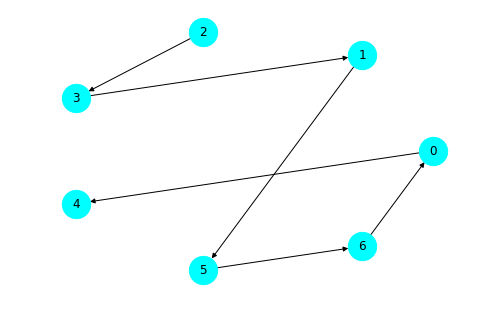

In [12]:
print("Probability vector :",model_1.get_p())
pairs = model_1.sample_pairs()
print(pairs)
draw_graph(pairs)

We can manually set the value of **p** when creating the model (or afterward) using the method *set_p()*.

Probability vector : [1, 0.5, 0.5, 0.2, 0.2, 0.1, 0.1]
[(0, 1), (0, 5), (1, 3), (2, 0), (2, 4), (2, 6)]


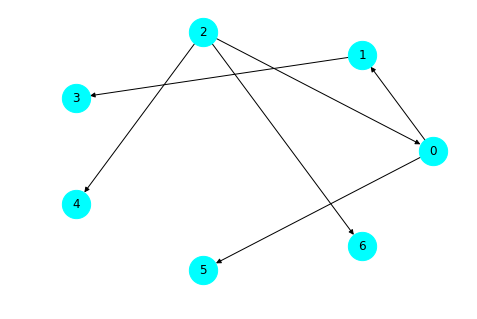

In [13]:
model_1.set_p([1,0.5,0.5,0.2,0.2,0.1,0.1])
print("Probability vector :",model_1.get_p())
pairs = model_1.sample_pairs()
print(pairs)
draw_graph(pairs)

We can also choose to drop some randomly chosen candidates. For that, we use the method *drop_k()*. Since it also alters the value of $\Pi$, it is important to specify again the value of $\phi$ or $\Pi$ to our model if we don't want to drop candidates anymore.

Probability vector : [0, 0, 0, 1, 0.5, 0.5, 0.2]
[(1, 2), (3, 1), (3, 5)]


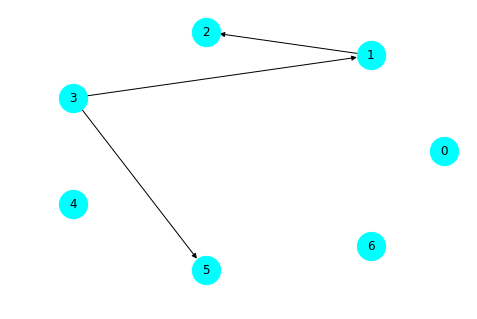

In [14]:
model_1.drop_k(3)
print("Probability vector :",model_1.get_p())
pairs = model_1.sample_pairs()
print(pairs)
draw_graph(pairs)

We can create **top-k** partial order with the method *top_k()*.

Probability vector : [1, 1, 1, 0, 0, 0, 0]
[(2, 5), (3, 2), (5, 0), (5, 1), (5, 4), (5, 6)]


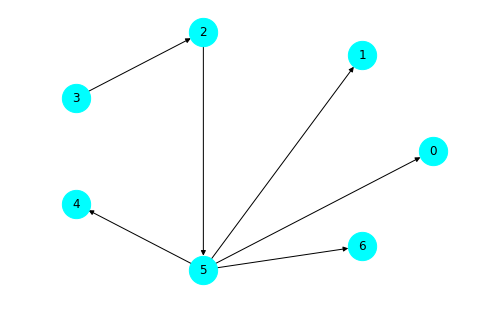

In [15]:
model_1.set_phi(0.5)
model_1.set_topk(3)
print("Probability vector :",model_1.get_p())
pairs = model_1.sample_pairs()
print(pairs)
draw_graph(pairs)

We can set every cell of **p** with the same value with *set_uniform_p()*.

Probability vector : [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[(0, 5), (1, 0), (1, 3), (2, 1), (2, 4), (4, 0), (5, 6)]


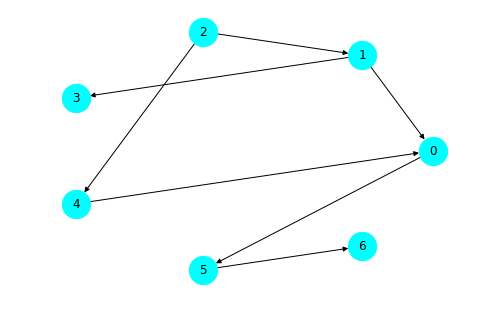

In [16]:
model_1.set_uniform_p(0.5)
print("Probability vector :",model_1.get_p())
pairs = model_1.sample_pairs()
print(pairs)
draw_graph(pairs)

We can set every cell of **p** with a random value between 0 and 1 with *set_random_p()*.

Probability vector : [0.41339561394809243, 0.03491127672694305, 0.8178507606209712, 0.04311476354420685, 0.325741741393605, 0.7445853073499551, 0.6138116088079381]
[(1, 2), (1, 3), (2, 4), (2, 5), (2, 6), (3, 5), (5, 0)]


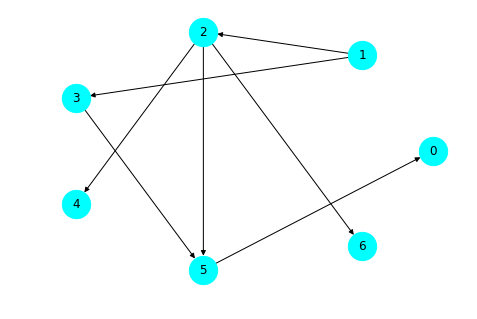

In [17]:
model_1.set_random_p()
print("Probability vector :",model_1.get_p())
pairs = model_1.sample_pairs()
print(pairs)
draw_graph(pairs)

If we want a probability vector which follow the rule $\exists \lambda \in [0,1], \tau \ge 0, \forall i \in [1,m], p_i = \lambda e^{-\tau (i-1)}$, we can use the following function:

Probability vector : [0.9        0.73685768 0.60328804 0.49393047 0.40439607 0.3310915
 0.27107479]
[(0, 3), (0, 4), (1, 5), (2, 3), (2, 4), (4, 1), (5, 6)]


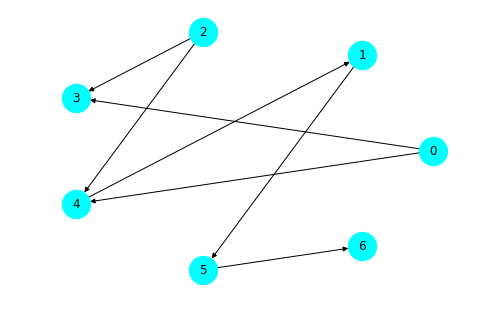

In [18]:
model_1.set_exp_p(0.9,0.2)
print("Probability vector :",model_1.get_p())
pairs = model_1.sample_pairs()
print(pairs)
draw_graph(pairs)

# Sample a Poset

We might want to study a partial order on its own, for that, we can use the Poset module which provides methods that facilitates computation of *Up* and *Down* value of candidates, the *roots* and the *leaves*. To sample a poset instead of a list with our model, we use the method *sample_a_poset()*.

Type: <class 'pycomsoc.poset.Poset'>
Pairs: [(0, 4), (0, 6), (1, 2), (2, 0), (4, 3), (5, 1)]
Roots: [5]
Leaves: [3, 6]
Is there Transitive Closure? False
Is there Transitive Cycle? 0
Candidates: [0, 1, 2, 3, 4, 5, 6]
Missing candidates: []
Direct successors of 3: []
Direct predecessors of 3: [4]
Elements better ranked than 3: {0, 1, 2, 3, 4, 5}
Elements less well ranked than 3: {3}
Height of the poset: 6


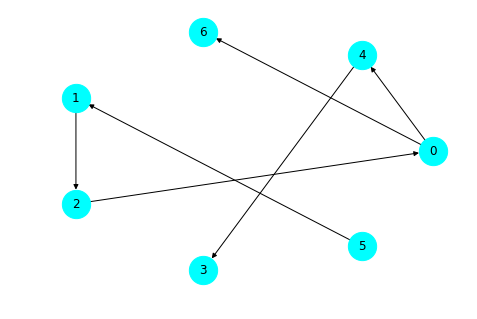

In [13]:
poset_ex = model_1.sample_a_poset()

print("Type:",type(poset_ex))
print("Pairs:",poset_ex.get_pairs())
print("Roots:",poset_ex.roots())
print("Leaves:",poset_ex.leaves())
print("Is there Transitive Closure?",poset_ex.is_there_TC())
print("Is there Transitive Cycle?",poset_ex.is_there_cycle())
print("Candidates:",poset_ex.get_elements())
print("Missing candidates:",poset_ex.missing(list(range(1,m))))
print("Direct successors of 3:",poset_ex.direct_down_i(3))
print("Direct predecessors of 3:",poset_ex.direct_up_i(3))
print("Elements better ranked than 3:",poset_ex.up_i(3))
print("Elements less well ranked than 3:",poset_ex.down_i(3))
print("Height of the poset:",poset_ex.get_height())
poset_ex.plot_graph()

# Population and Winners

Now that we know how to generate a partial order, we want to create a population of voter, and try to solve a problem on this population. For that, we use the *nw* and *pw* libraries, for **necessary winners** and **possible winners** respectively.

In [14]:
def all_nw(population,m,verbose=False):
    print("Necessary winner(s) for Borda:",nw.borda(population,m,verbose=verbose))
    print("Necessary winner(s) for Plurality:",nw.plurality(population,m,verbose=verbose))
    print("Necessary winner(s) for Veto:",nw.veto(population,m,verbose=verbose))
    print("Necessary winner(s) for 3-Approval:",nw.kapp(population,m,3,verbose=verbose))
    print("Necessary winner(s) for Formula 1 competition:",nw.positionalScoringRule(population,m,formula_1_rule,verbose=verbose))

In a population with only **full rankings**, it is not hard to see that there will always be at least one necessary winner. 

In [15]:
model_1.set_uniform_p(1)
model_1.shuffle_center()
population_full_ranking = model_1.generate_a_population(1000)
print(len(population_full_ranking))
print("Center:",model_1.get_center())

formula_1_rule = [25,18,15,12,10,8,6,4,2,1]

all_nw(population_full_ranking,m)

1000
Center: [5, 6, 1, 0, 2, 4, 3]
Necessary winner(s) for Borda: [5]
Necessary winner(s) for Plurality: [5]
Necessary winner(s) for Veto: [5]
Necessary winner(s) for 3-Approval: [5]
Necessary winner(s) for Formula 1 competition: [5]


But in a population in which **every voter have linear preferences but with missing candidates**, it is harder to find a necessary winner.

In [16]:
population_drop_candidates = []
model_1.shuffle_center()
for i in range(1000):
    k = np.random.randint(m-1)
    model_1.set_uniform_p(1)
    model_1.set_phi(0.5)
    model_1.drop_k(k)
    population_drop_candidates.append(model_1.sample_pairs())

all_nw(population_drop_candidates,m)


Necessary winner(s) for Borda: []
Necessary winner(s) for Plurality: []
Necessary winner(s) for Veto: []
Necessary winner(s) for 3-Approval: []
Necessary winner(s) for Formula 1 competition: []


We can then try to find **possible winners**. For *Plurality* and *Veto*, we can find the exact set of possible winners in PTIME. But for other rules, we can only find an approximation. The function will return 2 sets of candidates. The first one contains candidate who are possible winners for sure and the second one contains candidate for whom we can't conclude with this approximation. However, in most case, the second set is empty or with a small number of candidates.

In this particular case, every candidate is a possible winner, whatever is the rule.

In [17]:
def all_pw(population,m,shuffle=1,verbose=False):
    print("Possible winner(s) for plurality:",pw.plurality(population,m,verbose=verbose))
    print("Possible winner(s) for veto:",pw.veto(population,m,verbose=verbose))
    pw_borda_sure = pw.borda(population,m,shuffle=shuffle,verbose=verbose)
    pw_borda_sure.sort()
    print("Possible winner(s) for Borda: "+str(pw_borda_sure))
    pw_kapp_sure = pw.kapp(population,m,3,shuffle=shuffle,verbose=verbose)
    pw_kapp_sure.sort()
    print("Possible winner(s) for 3-Approval: "+str(pw_kapp_sure))
    pw_formula1_sure = pw.positionalScoringRule(population,m,formula_1_rule,shuffle=shuffle,verbose=verbose)
    pw_formula1_sure.sort()
    print("Possible winner(s) for Formula 1: "+str(pw_formula1_sure))

In [18]:
all_pw(population_drop_candidates,m)

Possible winner(s) for plurality: [0, 1, 2, 3, 4, 5, 6]
Possible winner(s) for veto: [0, 1, 2, 3, 4, 5, 6]
Possible winner(s) for Borda: [0, 1, 2, 3, 4, 5, 6]
Possible winner(s) for 3-Approval: [0, 1, 2, 3, 4, 5, 6]
Possible winner(s) for Formula 1: [0, 1, 2, 3, 4, 5, 6]


We can also generate a population of **top-k** partial orders

In [19]:
population_top_k = []
model_1.set_phi(0.5)
model_1.shuffle_center()
for i in range(1000):
    k = np.random.randint(1,m-1)
    model_1.set_topk(k)
    population_top_k.append(model_1.sample_pairs())
    
all_nw(population_top_k,m)
all_pw(population_top_k,m)


Necessary winner(s) for Borda: []
Necessary winner(s) for Plurality: [2]
Necessary winner(s) for Veto: []
Necessary winner(s) for 3-Approval: []
Necessary winner(s) for Formula 1 competition: [2]
Possible winner(s) for plurality: [2]
Possible winner(s) for veto: [0, 1, 2, 3, 4, 5, 6]
Possible winner(s) for Borda: [0, 2]
Possible winner(s) for 3-Approval: [0, 1, 2]
Possible winner(s) for Formula 1: [2]


We can create a population in which every pair has the same probability to appear. For instance, with *10* candidates, there are *45* possible pairs. If we want to simulate an experiment in which we ask the subject to order pairs for *30* in average, we set **p_i** at *30/45* for all *i*.

In [20]:
population_random_graph = []
model_1.shuffle_center()
model_1.set_uniform_p(30/45)
population_random_graph = model_1.generate_a_population(1000)
all_nw(population_random_graph,m)
all_pw(population_random_graph,m)

Necessary winner(s) for Borda: []
Necessary winner(s) for Plurality: []
Necessary winner(s) for Veto: []
Necessary winner(s) for 3-Approval: []
Necessary winner(s) for Formula 1 competition: []
Possible winner(s) for plurality: [0, 2]
Possible winner(s) for veto: [0, 1, 2]
Possible winner(s) for Borda: [0, 2]
Possible winner(s) for 3-Approval: [0, 2]
Possible winner(s) for Formula 1: [0, 2]
